# GenCode Explore

Explore the human RNA sequences from GenCode.

Assume user downloaded files from GenCode 38 [FTP](http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/)
to a subdirectory called data.

Improve on GenCode_Explore_101.ipynb

Use ORF_counter. 

Use MatPlotLib to make box plots and heat maps.

In [1]:
import time 
def show_time():
    t = time.time()
    s = time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))
    print(s)
show_time()

2021-06-01 15:54:37 Eastern Daylight Time


In [2]:
import numpy as np
import pandas as pd
import gzip
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(s.text)  # writes to cloud local, delete the file later?
    from RNA_describe import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_describe import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_describe():
    print("ERROR: Cannot use RNA_describe.")

CoLab not working. On my PC, use relative paths.


In [3]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'

In [4]:
def load_gencode(filename,label):
    DEFLINE='>'
    DELIM='|'
    EMPTY=''
    labels=[]  # usually 1 for protein-coding or 0 for non-coding
    seqs=[]    # usually string of ACGT
    lens=[]    # sequence length
    ids=[]     # GenCode transcript ID, always starts ENST
    one_seq = EMPTY
    one_id = None
    # Use gzip 'r' mode to open file in read-only mode.
    # Use gzip 't' mode to read each line of text as type string.
    with gzip.open (filename,'rt') as infile:
        for line in infile:
            if line[0]==DEFLINE:
                # Save the previous sequence if one exists.
                if not one_seq == EMPTY:
                    labels.append(label)
                    seqs.append(one_seq)
                    lens.append(len(one_seq))
                    ids.append(one_id)
                # Get ready to read the next sequence. 
                # Parse a GenCode defline that is formatted like this:
                # >transcript_ID|gene_ID|other_fields other_info|other_info
                one_id = line[1:].split(DELIM)[0]
                one_seq = EMPTY
            else:
                # Continue loading sequence lines till next defline.
                additional = line.rstrip()
                one_seq = one_seq + additional
        # Don't forget to save the last sequence after end-of-file.
        if not one_seq == EMPTY:
            labels.append(label)
            seqs.append(one_seq)
            lens.append(len(one_seq))
            ids.append(one_id)

    df1=pd.DataFrame(ids,columns=['tid'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

In [5]:
def get_the_facts(seqs,verbose=False):
    oc = ORF_counter()
    count = len(seqs)
    max_orf_lengths=np.zeros(count)
    for s in range(0,count):
        seq = seqs[s]
        oc.set_sequence(seq)
        max_orf = oc.get_max_orf_len()
        max_orf_lengths[s] = max_orf
    mean_max_orf = np.mean(max_orf_lengths,axis=0)
    std_max_orf = np.std(max_orf_lengths,axis=0)
    if verbose:
        print("mean longest ORF length:",int(mean_max_orf),"+/-",int(std_max_orf))
    return mean_max_orf

## Load the GenCode data.
Warning: GenCode has
over 100K protein-coding RNA (mRNA) 
and almost 50K non-coding RNA (lncRNA).

In [6]:
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
show_time()
pcdf=load_gencode(PC_FULLPATH,1)
print("PC seqs loaded:",len(pcdf))
show_time()
ncdf=load_gencode(NC_FULLPATH,0)
print("NC seqs loaded:",len(ncdf))
show_time()

2021-06-01 15:54:37 Eastern Daylight Time
PC seqs loaded: 106143
2021-06-01 15:54:42 Eastern Daylight Time
NC seqs loaded: 48752
2021-06-01 15:54:43 Eastern Daylight Time


In [7]:
print("Sorting PC...")
pcdf.sort_values('seqlen', ascending=True, inplace=True)
print("Sorting NC...")
ncdf.sort_values('seqlen', ascending=True, inplace=True)

Sorting PC...
Sorting NC...


## Subset by RNA length and analyze ORF lengths


In [8]:
# This is a fast way to slice if you have length thresholds.
# TO DO: choose length thresholds and apply to PC and NC RNA.
# For example: 200, 400, 800, 1600, 3200, 6400 (e.g. 200-399, etc.)
mask = (ncdf['sequence'].str.len() < 1000)
subset = ncdf.loc[mask]

# Here is one way to extract a list from a dataframe. 
mylist=subset['sequence'].tolist()

mask = (pcdf['sequence'].str.len() < 800)
subset = pcdf.loc[mask]
subset_list = subset['sequence'].tolist()


{'whiskers': [<matplotlib.lines.Line2D at 0x28719b99910>,
 'caps': [<matplotlib.lines.Line2D at 0x28719b99f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x28719b99580>],
 'medians': [<matplotlib.lines.Line2D at 0x28719ba66a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x28719ba6a30>],
 'means': []}

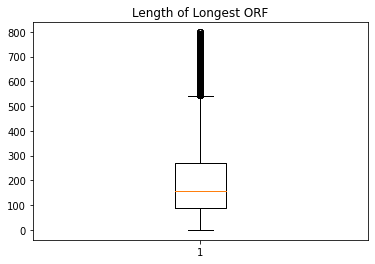

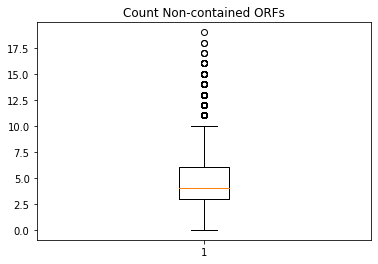

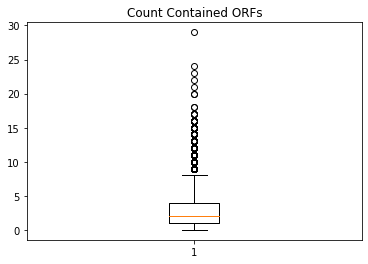

In [9]:
import matplotlib.pyplot as plt

max_len_data = []
max_cnt_data = []
contain_data = []

for i in range(0, len(subset_list)): #Actual is range(0, len(pcdf))
    #record = pcdf.iloc[i]
    #rna = record['sequence']
    rna = subset_list[i]
    #tid = record['tid']
    oc = ORF_counter()
    oc.set_sequence(rna)
    max_len = oc.get_max_orf_len()
    max_cnt = oc.count_maximal_orfs()
    contain = oc.count_contained_orfs()
    max_len_data.append(max_len)
    max_cnt_data.append(max_cnt)
    contain_data.append(contain)

fig1, ax1 = plt.subplots()
ax1.set_title('Length of Longest ORF')
ax1.boxplot(max_len_data)
fig2, ax2 = plt.subplots()
ax2.set_title('Count Non-contained ORFs')
ax2.boxplot(max_cnt_data)
fig3, ax3 = plt.subplots()
ax3.set_title('Count Contained ORFs')
ax3.boxplot(contain_data)

## Plotting examples
[boxplot doc](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html)  
[boxplot demo](https://matplotlib.org/stable/gallery/pyplots/boxplot_demo_pyplot.html)  
[heatmap examples](https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib) - scroll down!  